In [7]:
%load_ext autoreload
%autoreload 2

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

import sys
import numpy as np
import pandas as pd
from copy import deepcopy
from gensim.models import Word2Vec
from gensim.models import Phrases

import re
alteos = re.compile(r'( [!\?] )')

def revsplit(l):
    l = alteos.sub(r' \1 . ', l).rstrip("( \. )*\n")
    return [s.split() for s in l.split(" . ")]

def YelpReviews( stars = [1,2,3,4,5], prefix="train" ):
    for nstar in stars:
        for line in open("data/yelp%s%dstar.txt"%(prefix,nstar)):
            yield revsplit(line)
## grab all sentences; good bad and ugly
allsentences = [ s for r in YelpReviews() for s in r ]
len(allsentences)

docgrp = {'neg': [1,2], 'pos': [5]} 
reviews = { g: list(YelpReviews(docgrp[g])) for g in docgrp }

jointmodel = Word2Vec(workers=4, iter=10)
np.random.shuffle(allsentences)
jointmodel.build_vocab(allsentences)  

model = { g: deepcopy(jointmodel) for g in docgrp }
for g in model:
    print g
    sent = [l for r in reviews[g] for l in r]
    np.random.shuffle(sent)
    model[g].train(sent, total_examples=len(sent))

word = "food"
for g in docgrp: 
    print "\n"+g+":",
    for (w,v) in model[g].most_similar([word]):
        print w + " ",
 
testrev = { g: list(YelpReviews(docgrp[g], "test")) for g in docgrp }
sentences = [s for s in testrev['neg'][0]]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
neg
pos

neg: service  pizzabytheslice  fare  fazolis  execution  implementation  atrociously  unmistakably  overstatement  arianas  
pos: witha  cuisine  authetic  authentic  value  bolting  foood  grubs  atomsphere  fare 


In [2]:
model['neg'].score(sentences[:3])

array([  -16.79910088, -1430.9642334 , -1388.35742188], dtype=float32)

In [3]:
def getprobs(rev, grp):
    sentences =  [(i,s) for i,r in enumerate(rev) for s in r]
    eta = pd.DataFrame(
            { g: model[g].score([s for i,s in sentences])  
             for g in grp } )
    probs = eta.subtract( eta.max('columns'), 'rows') 
    probs = np.exp( probs )
    probs = probs.divide(probs.sum('columns'), "rows")
    probs['cnt'] = 1
    probs = probs.groupby([i for i,s in sentences]).sum()
    probs = probs.divide(probs["cnt"], 'rows').drop("cnt", 1)
    return(probs)


In [4]:
probs = {g: getprobs(testrev[g], docgrp) for g in docgrp }

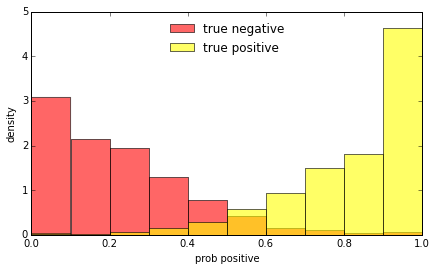

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(7,4))
plt.hist(probs['neg']['pos'],normed=1,
    color="red", alpha=.6, label="true negative", linewidth=1)
plt.hist(probs['pos']['pos'],normed=1,
    color="yellow", alpha=.6, label="true positive", linewidth=1)
plt.xlim([0,1])
plt.ylim([0,5])
plt.legend(frameon=False, loc='upper center')
plt.xlabel("prob positive")
plt.ylabel("density")
#fig.savefig("graphs/coarseprobs.pdf", format="pdf", bbox_inches="tight")
